<a href="https://colab.research.google.com/github/MikhailKuklin/time-series-analysis-forecasting/blob/main/notebooks/ts_analysis_statsmodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# libraries

import numpy as np
import pandas as pd
from matplotlib import dates
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# download data and parse date to datetime

df = pd.read_csv('espoo_2020_2022.csv',
                 parse_dates= {"date" : ["Year","m","d","Time"]},
                keep_date_col=True)

In [ ]:
# rename column

df['Temperature (C)'] = df['Air temperature (degC)']
df.drop(['Air temperature (degC)'],axis=1, inplace=True)

In [ ]:
# drop duplicated and nas

df=df.drop_duplicates()

df.dropna(axis=0,inplace=True)

df.shape

(17566, 7)

In [ ]:
# make date to be index

df = df.set_index('date')

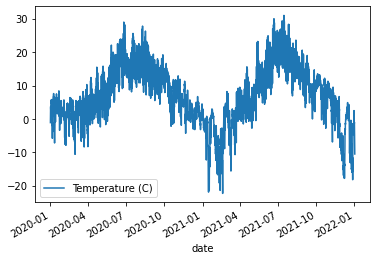

In [ ]:
# check temperatures to get the impression of a trend
# trend (upward, stationary, downward, seasonal) and cyclical compoonent (no trend)

df.plot.line(y='Temperature (C)')

In [ ]:
# use the Hodrick-Prescott filter to separate into a trend and cyclical component

temp_cycle, temp_trend = hpfilter(df['Temperature (C)'],lamb=1600)

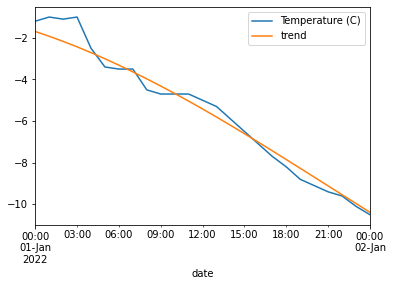

In [ ]:
# visualize trend

df['trend'] = temp_trend
df[['Temperature (C)','trend']]['2022-01-01':].plot();

Time series decomposition with ETS

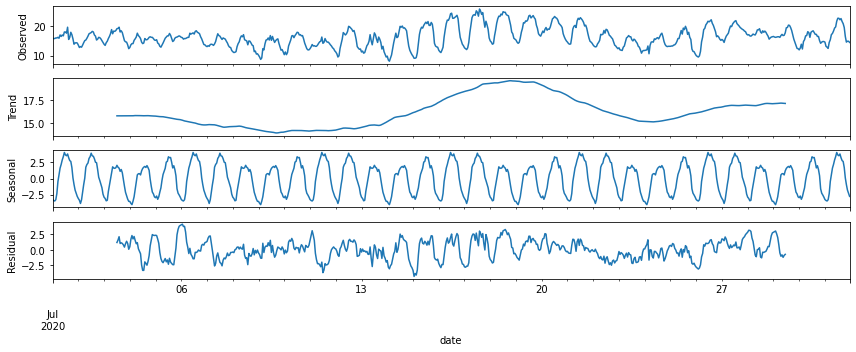

In [ ]:
# ETR models (Error-Trend-Seasonality) => to separate the different components




# make the model for July 2020 using additive model

df2 = df['2020-07-01':'2020-07-31']

result = seasonal_decompose(x=df2['Temperature (C)'], model='additive', freq=120)

rcParams['figure.figsize'] = 12,5
result.plot();

Exponentially Weighed Moving Average (EWMA)

In [ ]:
# expansion of SMA
# SMA -> smaller windows leads to more noice, rather than signal and 
#full peak is not reached due to the averaging
# also extreme points can skew SMA
# recent data is more weighted than older data -> exponents

df['1-month-SMA'] = df['Temperature (C)'].rolling(window=743).mean()

df['2-month-SMA'] = df['Temperature (C)'].rolling(window=1486).mean()

df3 = df[['Temperature (C)','1-month-SMA','2-month-SMA']]

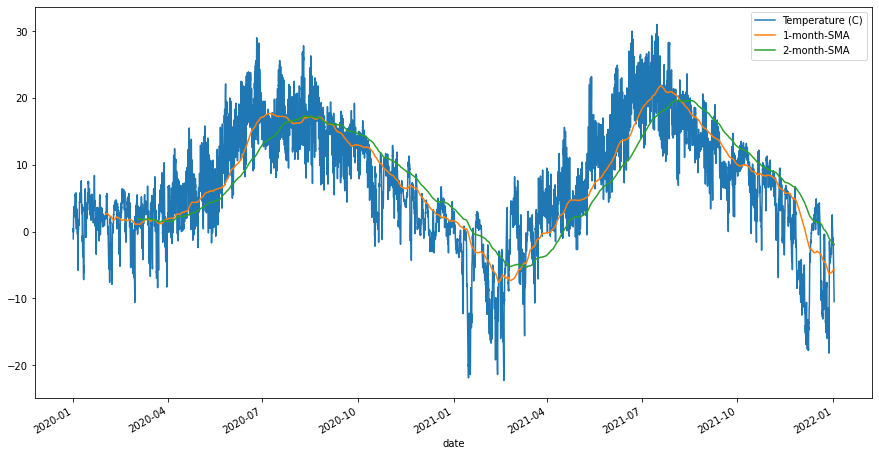

In [ ]:
df3.plot(figsize=(15,8));

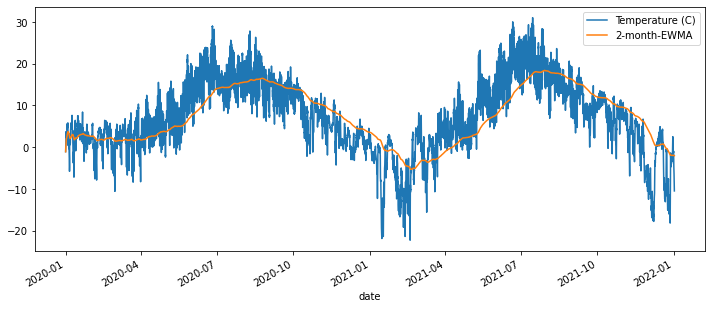

In [ ]:
# EWMA

df['2-month-EWMA'] = df['Temperature (C)'].ewm(span=1486).mean()

df[['Temperature (C)','2-month-EWMA']].plot()

Holt - Winters Methods Theory

In [ ]:
# EMWA = disadvantage: fails to account other contributing factors as trend and seasonality
# Holt - Winders => captures seasonality and trend (triple explonential smoothing)
# additive method => seasonal variations are about the same through the series
# multiplicative => not the same

df_ym = pd.read_csv('espoo_2020_2022.csv',
                 parse_dates= {"date" : ["Year","m"]},
                keep_date_col=True)

df_ym2 = df_ym.groupby(['date']).mean()

df_ym2.index.freq = "MS"

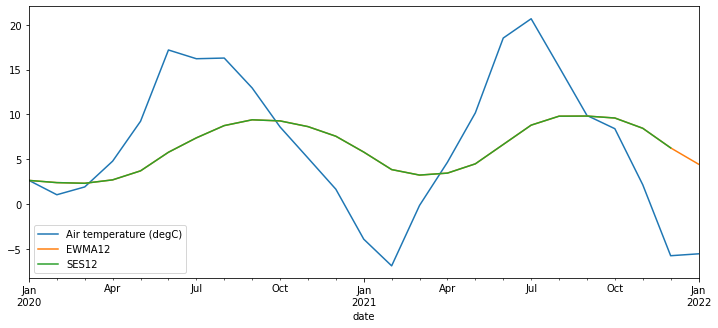

In [ ]:
# Simple Exponential Smoothing (variation of Hotl-Winters)
# level model

from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 12
alpha = 2/(span+1)

df_ym2['EWMA12'] = df_ym2['Air temperature (degC)'].ewm(alpha=alpha,adjust=False).mean()

df_ym2['SES12'] = SimpleExpSmoothing(df_ym2['Air temperature (degC)']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)

df_ym2.head()

df_ym2[['Air temperature (degC)','EWMA12','SES12']].plot()

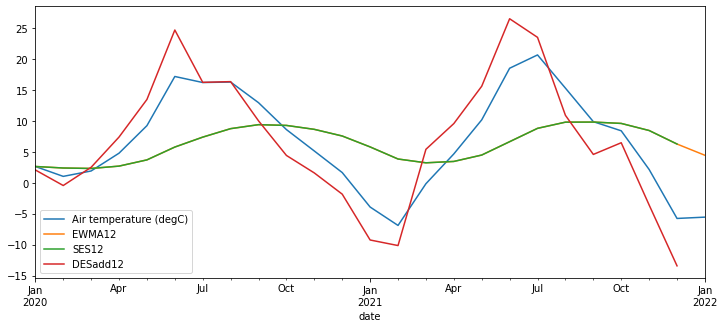

In [ ]:
# Double Exponential Smoothing
# can anticipate future increases or decreases (trend). Simple - only level

from statsmodels.tsa.holtwinters import ExponentialSmoothing

df_ym2['DESadd12'] = ExponentialSmoothing(df_ym2['Air temperature (degC)'], trend='add').fit().fittedvalues.shift(-1)

df_ym2[['Air temperature (degC)','EWMA12','SES12','DESadd12']].plot()

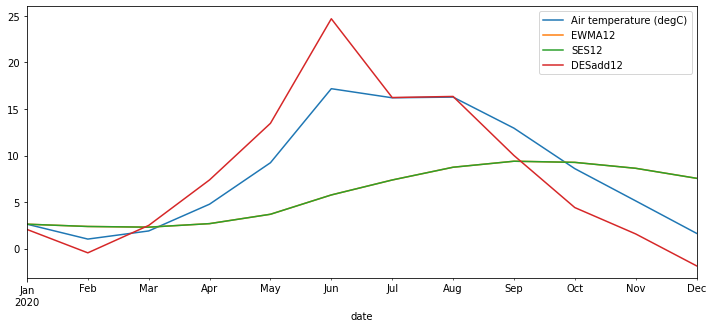

In [ ]:
df_ym2[['Air temperature (degC)','EWMA12','SES12','DESadd12']].iloc[:12].plot()

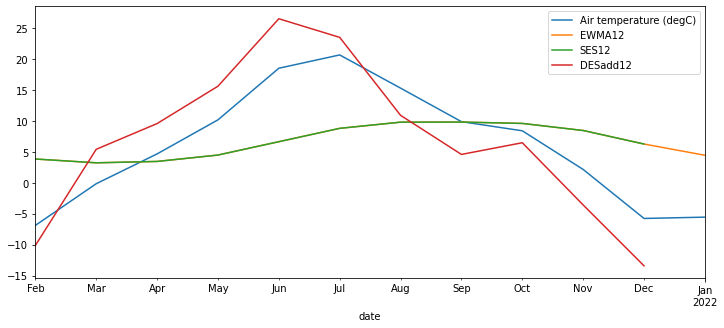

In [ ]:
df_ym2[['Air temperature (degC)','EWMA12','SES12','DESadd12']].iloc[-12:].plot()

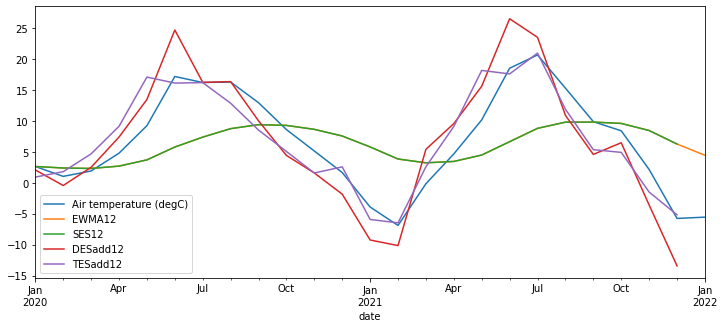

In [ ]:
# Triple Exponential Smoothing
# add support for both trend and seasonality

df_ym2['TESadd12'] = ExponentialSmoothing(df_ym2['Air temperature (degC)'], trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues.shift(-1)

df_ym2[['Air temperature (degC)','EWMA12','SES12','DESadd12','TESadd12']].plot()

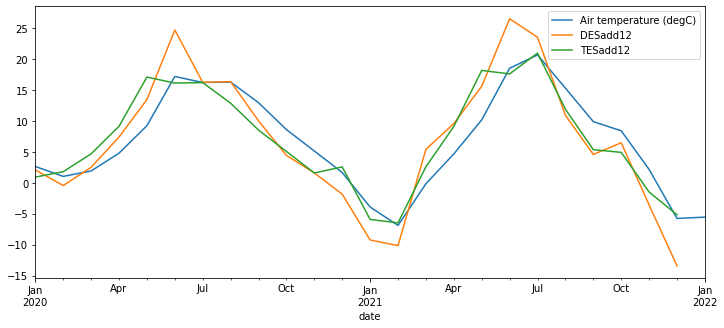

In [ ]:
df_ym2[['Air temperature (degC)','DESadd12','TESadd12']].plot()